# Capstone – Emotionality of Tweets: TF–IDF + Logistic Regression Baseline

Notebook advisories

This notebook was developed with conceptual and implementation influence from Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow.

AI Usage: AI assistance was used to help debug code, refine explanations, and assist comprehension of reinforcement learning concepts.

In [8]:
# Import necessary libraries
from pathlib import Path
from typing import List

import sys
import collections

# Third-party libraries
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
)
from sklearn.pipeline import Pipeline

PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.data_utils import load_and_prepare_emotion_splits

PROJECT_ROOT

PosixPath('/Users/maine/School/Machine Learning 2/Final_Project_Code')

## 1. Configuration and Label Definitions

In [9]:
# Configuration

DATA_DIR = PROJECT_ROOT / "data" / "primary_emotions"
print("Data directory:", DATA_DIR)

# TF–IDF configuration
NGRAM_RANGE = (1, 2)
MAX_FEATURES = 20_000

# Logistic Regression configuration
C_REG = 1.0
RANDOM_STATE = 42

EMOTION_ID2NAME = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise",
}

label_ids = sorted(EMOTION_ID2NAME.keys())
label_names = [EMOTION_ID2NAME[i] for i in label_ids]

print("Using emotion mapping:")
print(EMOTION_ID2NAME)

Data directory: /Users/maine/School/Machine Learning 2/Final_Project_Code/data/primary_emotions
Using emotion mapping:
{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}


## 2. Load and Prepare Dataset Splits

In [10]:
# Load standardized dataset splits

splits = load_and_prepare_emotion_splits(DATA_DIR, normalize=True)

X_train, y_train = splits.train_texts, splits.train_labels
X_val, y_val = splits.val_texts, splits.val_labels
X_test, y_test = splits.test_texts, splits.test_labels

print(f"# Train examples: {len(X_train)}")
print(f"# Val examples:   {len(X_val)}")
print(f"# Test examples:  {len(X_test)}")
print("Label mapping (from data_utils):")
print("label2id:", splits.label2id)
print("id2label:", splits.id2label)

# Train examples: 16000
# Val examples:   2000
# Test examples:  2000
Label mapping (from data_utils):
label2id: {np.int64(0): 0, np.int64(1): 1, np.int64(2): 2, np.int64(3): 3, np.int64(4): 4, np.int64(5): 5}
id2label: {0: np.int64(0), 1: np.int64(1), 2: np.int64(2), 3: np.int64(3), 4: np.int64(4), 5: np.int64(5)}


In [11]:
# Test run
def show_label_distribution(y: List[int], split_name: str) -> None:
    """
    Print a simple count of labels for a given split.
    """
    counter = collections.Counter(y)
    print(f"\nLabel distribution for {split_name}:")
    for label_id, count in sorted(counter.items()):
        label_name = EMOTION_ID2NAME.get(label_id, f"id_{label_id}")
        print(f"  {label_id} ({label_name}): {count} samples")

show_label_distribution(y_train, "train")
show_label_distribution(y_val, "validation")
show_label_distribution(y_test, "test")


Label distribution for train:
  0 (sadness): 4666 samples
  1 (joy): 5362 samples
  2 (love): 1304 samples
  3 (anger): 2159 samples
  4 (fear): 1937 samples
  5 (surprise): 572 samples

Label distribution for validation:
  0 (sadness): 550 samples
  1 (joy): 704 samples
  2 (love): 178 samples
  3 (anger): 275 samples
  4 (fear): 212 samples
  5 (surprise): 81 samples

Label distribution for test:
  0 (sadness): 581 samples
  1 (joy): 695 samples
  2 (love): 159 samples
  3 (anger): 275 samples
  4 (fear): 224 samples
  5 (surprise): 66 samples


## 3. Evaluation Helper

In [12]:
# Evaluation helper

def evaluate_predictions(
        y_true: List[int],
        y_pred: List[int],
        label_ids: List[int],
        label_names: List[str],
        split_name: str,
) -> None:
    """
    Compute and print classification metrics + confusion matrix for a given split.
    """

    acc = accuracy_score(y_true, y_pred)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true,
        y_pred,
        average="macro",
        zero_division=0,  # avoid crashes if a class is never predicted
    )

    print(f"\n=== {split_name} Metrics ===")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Macro P:   {precision_macro:.4f}")
    print(f"Macro R:   {recall_macro:.4f}")
    print(f"Macro F1:  {f1_macro:.4f}")

    label_names_str = [str(n) for n in label_names]
    print("\nPer-class report:")
    print(
        classification_report(
            y_true,
            y_pred,
            labels=label_ids,
            target_names=label_names_str,
            zero_division=0,
        )
    )

    cm = confusion_matrix(y_true, y_pred, labels=label_ids)
    print("Confusion matrix (rows = true, cols = pred):")
    print(cm)

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.figure.colorbar(im, ax=ax)

    ax.set(
        xticks=np.arange(len(label_names_str)),
        yticks=np.arange(len(label_names_str)),
        xticklabels=label_names_str,
        yticklabels=label_names_str,
        ylabel="True label",
        xlabel="Predicted label",
        title=f"{split_name} Confusion Matrix",
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.tight_layout()
    plt.show()

## 4. TF–IDF + Logistic Regression Pipeline

In [13]:
# Build the TF-IDF + Logistic Regression pipeline

def build_tfidf_logreg_pipeline() -> Pipeline:
    vectorizer = TfidfVectorizer(
        lowercase=True,
        ngram_range=NGRAM_RANGE,
        max_features=MAX_FEATURES,
    )

    clf = LogisticRegression(
        C=C_REG,
        max_iter=1000,
        solver="lbfgs",
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )

    pipeline = Pipeline(
        steps=[
            ("tfidf", vectorizer),
            ("logreg", clf),
        ]
    )
    return pipeline

# Test check
baseline_model = build_tfidf_logreg_pipeline()
baseline_model

,steps,"[('tfidf', ...), ('logreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


## 5. Train and Evaluate the Baseline Model


Fitting TF-IDF + Logistic Regression baseline...

Predicting on validation set...

=== Validation Metrics ===
Accuracy:  0.8340
Macro P:   0.8709
Macro R:   0.7077
Macro F1:  0.7594

Per-class report:
              precision    recall  f1-score   support

     sadness       0.82      0.93      0.87       550
         joy       0.80      0.96      0.87       704
        love       0.89      0.52      0.66       178
       anger       0.94      0.76      0.84       275
        fear       0.89      0.67      0.77       212
    surprise       0.89      0.40      0.55        81

    accuracy                           0.83      2000
   macro avg       0.87      0.71      0.76      2000
weighted avg       0.84      0.83      0.82      2000

Confusion matrix (rows = true, cols = pred):
[[514  26   1   5   3   1]
 [ 13 678   9   3   1   0]
 [ 22  62  93   1   0   0]
 [ 36  26   1 208   4   0]
 [ 28  34   0   4 143   3]
 [ 14  24   0   1  10  32]]


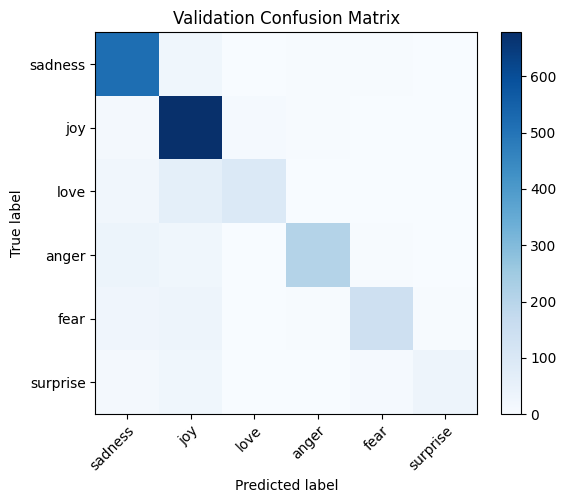


Predicting on test set...

=== Test Metrics ===
Accuracy:  0.8315
Macro P:   0.8673
Macro R:   0.6842
Macro F1:  0.7330

Per-class report:
              precision    recall  f1-score   support

     sadness       0.87      0.91      0.89       581
         joy       0.78      0.97      0.86       695
        love       0.84      0.50      0.63       159
       anger       0.90      0.73      0.81       275
        fear       0.87      0.71      0.78       224
    surprise       0.95      0.27      0.42        66

    accuracy                           0.83      2000
   macro avg       0.87      0.68      0.73      2000
weighted avg       0.84      0.83      0.82      2000

Confusion matrix (rows = true, cols = pred):
[[530  35   1  12   3   0]
 [  8 673  13   0   1   0]
 [ 10  67  80   2   0   0]
 [ 29  37   1 202   6   0]
 [ 29  27   0   7 160   1]
 [  6  27   0   1  14  18]]


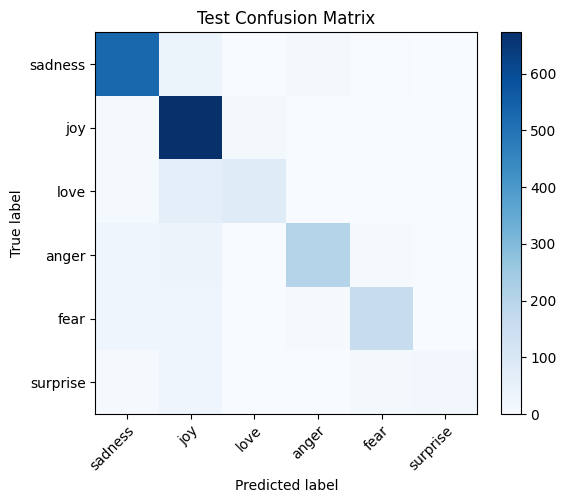

In [14]:
# Fit on training data
print("\nFitting TF-IDF + Logistic Regression baseline...")
baseline_model.fit(X_train, y_train)

# Evaluate on validation split
print("\nPredicting on validation set...")
val_pred = baseline_model.predict(X_val)
evaluate_predictions(y_val, val_pred, label_ids, label_names, split_name="Validation")

# Evaluate on test split
print("\nPredicting on test set...")
test_pred = baseline_model.predict(X_test)
evaluate_predictions(y_test, test_pred, label_ids, label_names, split_name="Test")

## 6. Discussion and Conclusion

This notebook implemented a TF–IDF + Logistic Regression baseline for six-way emotion classification on tweets. Tweets were represented with unigram–bigram TF–IDF features, and a multinomial Logistic Regression classifier was trained on standardized train/validation/test splits shared with the other models.

On both validation and test sets, the model reached solid overall performance. Accuracy of around %83 and Macro-F1 of approximately %73 were observed, indicating that the model does somewhat well at picking up the main emotional tones in tweets.

Because the entire pipeline is fast to train and easy to interpret, it serves as a reference point for the project. Comparing our next models against this baseline highlights what is gained—in terms of macro-F1, minority-class performance, and handling of nuanced tone.